In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape


# Load the dataset
df = pd.read_csv('_annotations.csv')

# Path to the original images folder
original_path = 'train/'

# Read images and labels
images = []
labels = []

for index, row in df.iterrows():
    img_name = row['filename']
    label = row['class']
    
    img_path = os.path.join(original_path, img_name)
    
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize images
images = images / 255.0

# Map color names to categories
color_mapping = {
    'blue': 0,
    'green': 1,
    'red': 2,
    'yellow': 3,
    'orange': 4,
    'purple': 5,
    'pink': 6,
    'brown': 7,
    'black': 8,
    'white': 9,
    'gray': 10
}

# Convert labels to categorical format based on color names
labels_encoded = np.array([color_mapping[label] for label in labels])

# Convert labels to categorical format
y_cat = to_categorical(labels_encoded, num_classes=len(color_mapping))

# Shuffle the data
images, y_cat = shuffle(images, y_cat, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, y_cat, test_size=0.2, random_state=42)


c:\Users\arnim\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\arnim\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\arnim\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam


# Define the CNN-LSTM model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Reshape for LSTM
model.add(Reshape((32, 1152)))  # 32 time steps, 1152 features

# LSTM Layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

# Flatten the LSTM output
model.add(Flatten())

# ANN Layers after LSTM
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(color_mapping), activation='softmax'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Save the dataset and its labels to a new .npz file
np.savez('color_dataset.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
np.save('color_classes.npy', color_mapping)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       147584    
                                                        

In [3]:
class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.85):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] >= self.target_accuracy:
            print(f"\nReached target validation accuracy of {self.target_accuracy * 100:.2f}%.")
            self.model.stop_training = True


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model_color.h5', save_best_only=True)
custom_callback = CustomCallback(target_accuracy=0.85)  # Use your custom callback here

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, custom_callback]
)


Epoch 1/50
 9/10 [==========================>...] - ETA: 2s - loss: 2.3362 - accuracy: 0.2169

KeyboardInterrupt: 

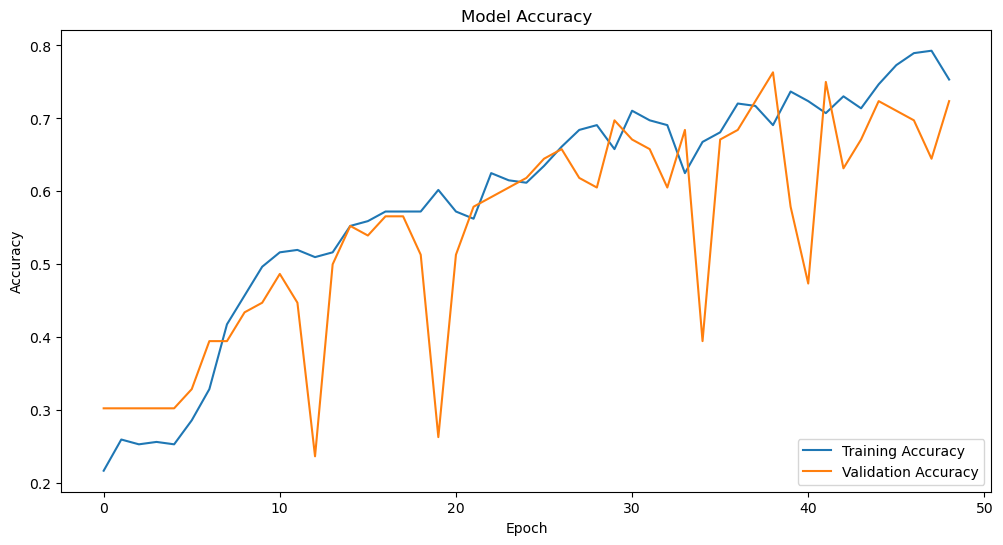

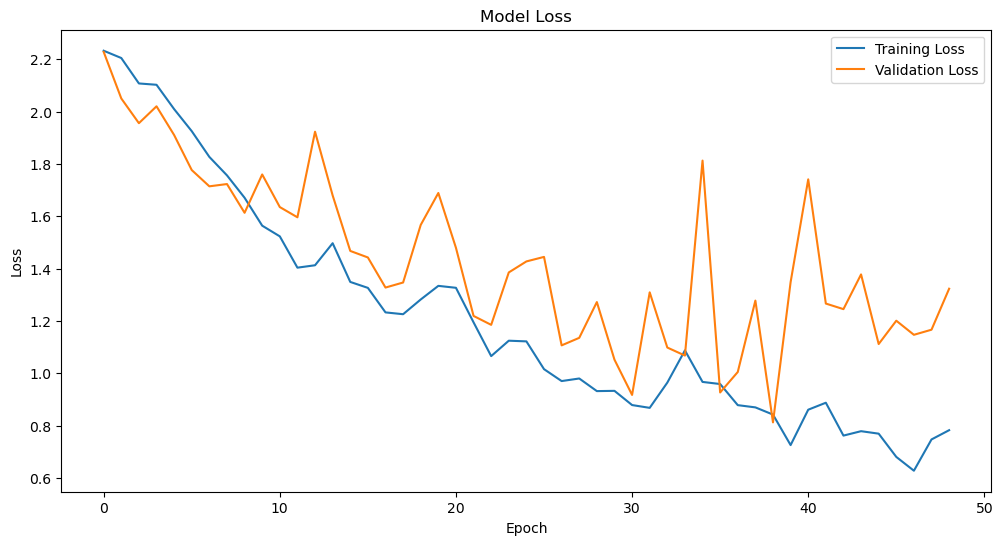

In [ ]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()




In [ ]:
model.save('color_classifier_model.h5')